# Credit Card fraud detection
---
Preparing the data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:02<00:00, 16.0MB/s]
100% 66.0M/66.0M [00:02<00:00, 30.5MB/s]


In [4]:
!unzip creditcardfraud

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/creditcard.csv')

## Exploring the data
---
Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# Lets check for missing values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Lets look at out target feature

In [12]:
df.Class.unique()

array([0, 1])

### Lets look at its distribution

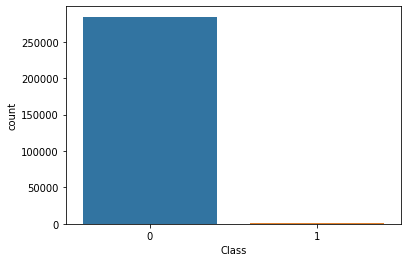

In [15]:
sns.countplot(x='Class', data=df)

### The distribution looks very uneven, lets explore the exact number of samples in each category

In [19]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [25]:
print("The ratio of fraud samples to not fraud samples is {0:.2f}:1000".format(492/284315*1000))

The ratio of fraud samples to not fraud samples is 1.73:1000


### Because of this trend, our model will not be able to train efficeintly and will probably overfit to the not fraud data, so we resample the data to maintain a ratio of 1:1.5 for fraud v not fraud data

In [0]:
nf = df[df.Class==0]
f = df[df.Class==1]

In [0]:
nf = nf.sample(int(492*1.5))
data = f.append(nf, ignore_index=True)

In [36]:
data.shape

(1230, 31)

## Lets transform the data into X,y with the correct dimensions so that it can be fed into a Neural Net

In [0]:
X = data.drop(columns=['Class'])
y = data.Class

In [40]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                            test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

In [130]:
print('The shape of X_train : {}'.format(X_train.shape))
print('The shape of y_train : {}'.format(y_train.shape))
print('The shape of X_validate : {}'.format(X_validate.shape))
print('The shape of y_validate : {}'.format(y_validate.shape))
print('The shape of X_test : {}'.format(X_test.shape))
print('The shape of y_test : {}'.format(y_test.shape))

The shape of X_train : (159491, 30, 1)
The shape of y_train : (159491,)
The shape of X_validate : (39873, 30, 1)
The shape of y_validate : (39873,)
The shape of X_test : (85443, 30, 1)
The shape of y_test : (85443,)


In [0]:
X_train=np.expand_dims(X_train, -1)
X_test=np.expand_dims(X_test, -1)
X_validate=np.expand_dims(X_validate, -1)

In [131]:
X_train[0].shape

(30, 1)

## Lets build the model

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam

In [118]:
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape=(30,1)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(128, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 32)            128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 29, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 27, 128)          

In [153]:
from tensorflow.keras.metrics import AUC
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
trained = model.fit(X_train, y_train, 
              validation_data=(X_validate, y_validate),
              batch_size=500, 
              epochs=20, 
             )

Epoch 1/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0044 - val_accuracy: 0.9994
Epoch 2/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0047 - val_accuracy: 0.9992
Epoch 3/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0046 - val_accuracy: 0.9994
Epoch 4/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0045 - val_accuracy: 0.9994
Epoch 5/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0044 - val_accuracy: 0.9993
Epoch 6/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0045 - val_accuracy: 0.9994
Epoch 7/20
319/319 [==============================] - 3s 9ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0043 - val_accuracy: 0.9994
Epoch 

In [0]:
def plotLearningCurve(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.ylim((0.98,1))
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

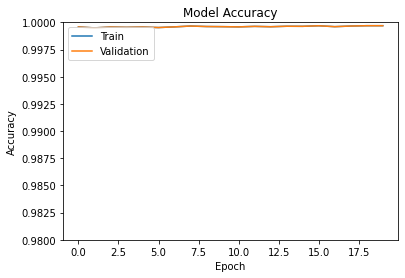

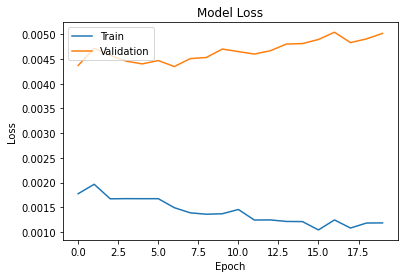

In [162]:
plotLearningCurve(trained)

In [164]:
score = model.evaluate(X_test, y_test)

2671/2671 [==============================] - 8s 3ms/step - loss: 0.0027 - accuracy: 0.9995


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def print_score(label, prediction, train=True):
    if train:
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print("Classification Report:", end='')
        print(f"\tPrecision Score: {precision_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tRecall Score: {recall_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tF1 score: {f1_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print("Classification Report:", end='')
        print(f"\tPrecision Score: {precision_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tRecall Score: {recall_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tF1 score: {f1_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

In [166]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

Train Result:
Accuracy Score: 99.99%
_______________________________________________
Classification Report:	Precision Score: 98.92%
			Recall Score: 95.47%
			F1 score: 97.16%
_______________________________________________
Confusion Matrix: 
 [[159201      3]
 [    13    274]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
Classification Report:	Precision Score: 83.58%
			Recall Score: 82.35%
			F1 score: 82.96%
_______________________________________________
Confusion Matrix: 
 [[85285    22]
 [   24   112]]



# 99.99 % accuracy on the training data and 99.5% accuracy on the testing data !!!
--- 
### Now lets put the system to the test and expose it to the whole dataset and see how it performs :O 

In [170]:
# Lets check out model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 32)            128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 29, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 27, 128)          

In [0]:
X_complete = df.drop(columns=['Class'])
y_complete = df.Class

In [172]:
print("The shape of X_complete: {}".format(X_complete.shape))
print("The shape of y_complete: {}".format(y_complete.shape))

The shape of X_complete: (284807, 30)
The shape of y_complete: (284807,)


In [0]:
# performing the necessary pre-processing on the data
X_complete=scaler.fit_transform(X_complete)
X_complete=np.expand_dims(X_complete, -1)
y_complete = y_complete.to_numpy()

In [183]:
# checking if we have the original data 
complete_df = pd.DataFrame(y_complete)
complete_df.columns = ['labels']
complete_df.labels.value_counts()

0    284315
1       492
Name: labels, dtype: int64

## Now lets evaluate the data

In [174]:
model.evaluate(X_complete,y_complete, verbose=1)

8901/8901 [==============================] - 27s 3ms/step - loss: 0.0018 - accuracy: 0.9997


[0.0017879708902910352, 0.9996980428695679]

## ***We have achieved ~ 100 % on the data provided, the model is ready to tested on unseen data !!*** 